In [70]:
import numpy as np
print(np.__version__)

import scipy as sp
print(sp.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

1.10.0.dev0+9dba7a4
0.16.0.dev0+bcf5fcd


## `scipy.sparse`

<img src="files/sparse_graph.png"/>

### Types of sparse storage: lil

In [98]:
A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]
S = sparse.lil_matrix(A)

print("Values:      ", S.data)
print("Row-indices: ", S.rows)

Values:       [[1, 2] [3, 4, 5] [3, 3] [1]]
Row-indices:  [[0, 3] [0, 1, 2] [1, 2] [3]]


### Types of sparse storage: coo

In [100]:
A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]
S = sparse.coo_matrix(A)

print("Values:      ", S.data)
print("Row-indices: ", S.row)
print("Col-indices: ", S.col)

Values:       [1 2 3 4 5 3 3 1]
Row-indices:  [0 0 1 1 1 2 2 3]
Col-indices:  [0 3 0 1 2 1 2 3]


### Types of sparse storage: CSR

In [97]:
import scipy.sparse as sparse

A = [[1, 0, 0, 2],
     [3, 4, 5, 0],
     [0, 3, 3, 0],
     [0, 0, 0, 1]]

S = sparse.csr_matrix(A)

print("Values:              ", S.data)
print("Positions:           ", S.indices)
print("Index into positions:", S.indptr)

Values:               [1 2 3 4 5 3 3 1]
Positions:            [0 3 0 1 2 1 2 3]
Index into positions: [0 2 5 7 8]


All these containers trade off different construction, access and manipulation speeds.

## PageRank and `scipy.linalg`

Walk-through of: http://www.ams.org/samplings/feature-column/fcarc-pagerank

Let's start by constructing a tiny world-wide-web, where we have several pages linking to one another.

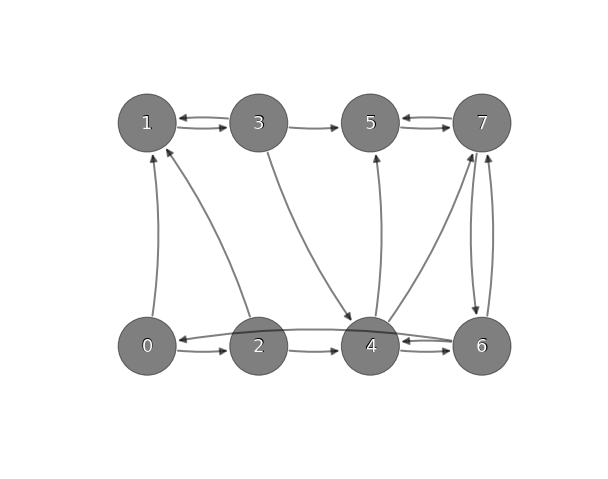

In [141]:
import networkx as nx
g = nx.DiGraph()
g.add_nodes_from(range(0, 7))
g.add_edges_from([(0,1), (0,2),
                  (1,3),
                  (2,1), (2,4),
                  (3,1), (3,5), (3,4),
                  (4,5), (4,6), (4,7),
                  (5,7),
                  (6,0), (6,4), (6,7),
                  (7,5), (7,6)])

n = np.arange(7)
rect_pos = {}
for col in range(4):
    for row in range(2):
        rect_pos[col * 2 + row] = (col / 2., row)
        
import nxdraw
nxdraw.draw_network(g, rect_pos)

## Or use built-in command:
# nx.draw_spring(g, with_labels=True)

Each node donates its popularity to other nodes.
<br/>
For example, node 1 has two links--to nodes 2 and 3. Each of those
nodes therefore gets $\frac{1}{2}$ of its popularity.
<br/>
This definition doesn't help us to find each page's popularity though, because
to find it we first need to know the popularity of its neighbours.
<br/>
To proceed, let's first write this problem in linear form:<br/><br/>

$$\mathbf{p} = \mathrm{H} \mathbf{p}$$
<br/>
In other words, each node's popularity can be written as a weighted
combination of the popularities of all nodes.  For those of you with a background
in linear algebra, the above should look familiar, especially if we rewrite it as
follow:<br/><br/>

$$\lambda \mathbf{p} = \mathrm{H} \mathbf{p}$$
<br/>

with $\lambda = 1$ is an eigenvalue problem.  Therefore, if we can find
the eigenvector of $\mathrm{H}$ associated with eigenvalue 1, we've found
the PageRank vector, $\mathbf{p}$.

In [170]:
# Build adjacency matrix
A = nx.adjacency_matrix(g).T

print(type(A))
print()

A = A.toarray()

print(A)
print()

# Convert nr of links to percentage.  Node can't
# donate more than 100% of popularity, so columns
# must sum to one.
H = A / np.sum(A, axis=0)

np.set_printoptions(precision=2)
print(H)

<class 'scipy.sparse.csc.csc_matrix'>

[[0 0 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 0]
 [0 0 0 1 1 0 0 1]
 [0 0 0 0 1 0 0 1]
 [0 0 0 0 1 1 1 0]]

[[ 0.    0.    0.    0.    0.    0.    0.33  0.  ]
 [ 0.5   0.    0.5   0.33  0.    0.    0.    0.  ]
 [ 0.5   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.5   0.33  0.    0.    0.33  0.  ]
 [ 0.    0.    0.    0.33  0.33  0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.33  0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.33  1.    0.33  0.  ]]


<span class="exercise">
    <br/><br/><br/>
    **Exercise:** Find the eigenvector associated with eigenvalue 1, and determine the page rank.
    <br/><br/><br/><br/>
</span>

In [171]:
e, v = np.linalg.eig(H)
e

array([  1.00e+00+0.j  ,   4.25e-01+0.29j,   4.25e-01-0.29j,
        -8.70e-01+0.j  ,  -2.12e-01+0.25j,  -2.12e-01-0.25j,
        -2.81e-16+0.j  ,  -5.57e-01+0.j  ])

In [176]:
v0 = np.abs(v[:, 0])
print('v corresponding to λ=1:', v0)

page_rank = (v0 / v0.max())

print('Page rank:', page_rank)

v corresponding to λ=1: [ 0.14  0.16  0.07  0.16  0.23  0.47  0.42  0.69]
Page rank: [ 0.2   0.23  0.1   0.23  0.33  0.69  0.61  1.  ]


Let's plot nodes according to their pagerank:

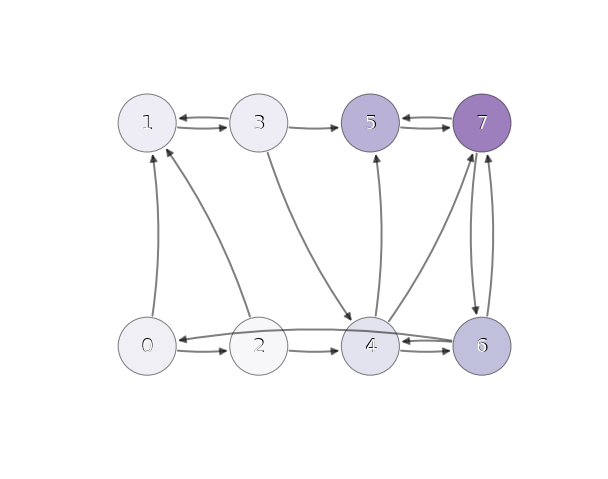

In [179]:
import nxdraw

nxdraw.draw_network(g,
            rect_pos,
            node_color=page_rank,
            cmap=plt.cm.Purples)

<span class="exercise">
**Exercise:** Investigate the cost of computing page-rank for a larger internet.
</span>
    
 1. Construct a random adjacency matrix for N nodes, with N varying between 100 and 800.
 2. Web pages are typically not very densely connected, so set at least 80%
    of the matrix to zero.
 3. Normalise the adjacency matrix, ensuring that columns sum to 1.
 4. Compute the eigenvector corresponding to an eigenvalue of one,
    using NumPy as illustrated above.
 5. Now, convert the array to a sparse matrix, and
    find a tool in ``scipy.sparse.linalg`` with which to do the same.
 6. How do the timings compare?

In [180]:
A = np.random.random((800, 800))
A[A > 0.2] = 0
H = A / np.sum(A, axis=0)

In [181]:
import numpy.linalg
%timeit np.linalg.eig(H)

1 loops, best of 3: 2.27 s per loop


In [182]:
import scipy.sparse as sparse
import scipy.sparse.linalg

Hs = sparse.csc_matrix(H)
%timeit sparse.linalg.eigs(Hs)

1 loops, best of 3: 1.65 s per loop


Clearly, Google has some magic machinery running in the background,
given the size of the matrix they have to work with!